# load and clean the data

In [2]:
import numpy as np
import pandas as pd

In [3]:
# load the data 
df = pd.read_excel('or_hamidbar_recipts_since_march2021.xlsx')
df_2 = pd.read_excel('recipts_old_acount.xlsx')
df = df.append(df_2)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# select important columns
df = df[['סטטוס',
 'תאריך מסמך',
 'שם לקוח',
 'אימייל',
 'טלפון',
 'סכום',
 'נייד']]

In [5]:
# translate column names 
df = df.set_axis(['status', 'date', 'name', 'mail', 'phone', 'amount', 'cellphone'], axis=1, inplace=False)

In [6]:
df.dtypes

status               object
date         datetime64[ns]
name                 object
mail                 object
phone                object
amount              float64
cellphone            object
dtype: object

In [7]:
# fix column types 
for column_name in df.columns:
    if column_name not in ['date', 'amount']:
        df[column_name] = df[column_name].astype('string')
df.dtypes

status               string
date         datetime64[ns]
name                 string
mail                 string
phone                string
amount              float64
cellphone            string
dtype: object

In [8]:
# remove all price bids that didnt brought a sell 
df = df.loc[df['status'] == 'סגור/שולם']
set(df.status)

{'סגור/שולם'}

In [9]:
df.drop(['status'], axis=1, inplace=True)

In [10]:
#df.head()

# find a key to group by

In [11]:
df.isna().sum()

date            0
name            0
mail         1579
phone        3813
amount          0
cellphone    6398
dtype: int64

In [12]:
def print_null_percentages(df):
    for column in df.columns:
         print(f"null percentage in the {column} columns is: {round(len(df.loc[df[column].isna()])/len(df) * 100, 3)}%")

In [13]:
print_null_percentages(df)

null percentage in the date columns is: 0.0%
null percentage in the name columns is: 0.0%
null percentage in the mail columns is: 15.215%
null percentage in the phone columns is: 36.741%
null percentage in the amount columns is: 0.0%
null percentage in the cellphone columns is: 61.65%


In [ ]:
# I will combine the cellphone and phone columns, in hope that they can complete each other missing values. 

In [15]:
# I will cobine the phone and cellphone columns. 
df['phone'] = df['phone'].apply(lambda x: np.NaN if len(str(x)) < 10 else x)
df['phone'] = df[['phone', 'cellphone']].apply(lambda x: x.phone if not pd.isna(x.phone) else x.cellphone, axis=1)
df['phone'] = df['phone'].apply(lambda x: np.NaN if len(str(x)) < 10 else x)

In [16]:
print_null_percentages(df)

null percentage in the date columns is: 0.0%
null percentage in the name columns is: 0.0%
null percentage in the mail columns is: 15.215%
null percentage in the phone columns is: 2.534%
null percentage in the amount columns is: 0.0%
null percentage in the cellphone columns is: 61.65%


In [17]:
df.isna().sum()

date            0
name            0
mail         1579
phone         263
amount          0
cellphone    6398
dtype: int64

In [18]:
df.dtypes

date         datetime64[ns]
name                 string
mail                 string
phone                object
amount              float64
cellphone            string
dtype: object

In [19]:
df['phone'] = df['phone'].astype('string')

In [20]:
# we will remove the customers from urim and have null phone number, of course only the ones from urim that urim is a part of their name
df = df[((df["name"].str.contains("אורים") == False) & (df["phone"].isna() == True)) | (df["phone"].isna() == False)]

In [21]:
print_null_percentages(df)
print("------------------------")
df.isna().sum()

null percentage in the date columns is: 0.0%
null percentage in the name columns is: 0.0%
null percentage in the mail columns is: 15.227%
null percentage in the phone columns is: 2.459%
null percentage in the amount columns is: 0.0%
null percentage in the cellphone columns is: 61.62%
------------------------


date            0
name            0
mail         1579
phone         255
amount          0
cellphone    6390
dtype: int64

In [22]:
# a final check that phone number is a uniq key 
print(f"The unique phone numbers percentage from all phone numbers are {len(df['phone'].drop_duplicates()) / len(df) * 100}%") 
print("it is not a problem because a customer supposed to appear more than once in this list, because it is a purchases list.")

The unique phone numbers percentage from all phone numbers are 44.70588235294118%
it is not a problem because a customer supposed to appear more than once in this list, because it is a purchases list.


In [23]:
# for the reminder 252 I will use the phone\name as a key, it is not optimal of course
df.rename({"phone":"phone_or_name_key"}, axis=1, inplace=True)

In [24]:
df.dtypes

date                 datetime64[ns]
name                         string
mail                         string
phone_or_name_key            string
amount                      float64
cellphone                    string
dtype: object

In [25]:
df["phone_or_name_key"] = df["phone_or_name_key"].fillna("")
df["phone_or_name_key"] = df["phone_or_name_key"].astype("string")
df["phone_or_name_key"] = df.apply(lambda x: x.phone_or_name_key if len(x.phone_or_name_key) > 8 else x.name, axis=1)

In [26]:
df["phone_or_name_key"] = df["phone_or_name_key"].astype("string")
df["phone_or_name_key"] = df["phone_or_name_key"].fillna("")
df["phone_or_name_key"] = df.apply(lambda x: x.phone_or_name_key if len(x.phone_or_name_key) > 1 else np.NaN, axis=1)

In [27]:
print_null_percentages(df)
print("------------------------")
df.isna().sum()

null percentage in the date columns is: 0.0%
null percentage in the name columns is: 0.0%
null percentage in the mail columns is: 15.227%
null percentage in the phone_or_name_key columns is: 0.0%
null percentage in the amount columns is: 0.0%
null percentage in the cellphone columns is: 61.62%
------------------------


date                    0
name                    0
mail                 1579
phone_or_name_key       0
amount                  0
cellphone            6390
dtype: int64

In [ ]:
# now we have a key, and we can start to look into the top customers. 

# choose the intersting customers 

In [28]:
back_up_df = df

In [29]:
#df.head()

In [30]:
# aggregations
df = df.groupby(['phone_or_name_key', 'name']).agg({'date':['count','max'], 'amount':'sum'}).reset_index()

In [31]:
df = df.set_axis(['phone_or_name_key','name', 'num_of_purchases', 'last_purchase_date', 'purchases_sum'], axis=1, inplace=False)
#df.head(2)

In [32]:
# filter by last order date 
import datetime
months_since_last_order = 10
df = df.loc[df.last_purchase_date < datetime.datetime.now() - datetime.timedelta(days = 30 * months_since_last_order)]

In [33]:
thresholds = [ x * 1000 for x in range (1,11)]
groups_dic = {}
for threshold in thresholds:
    groups_dic[threshold] = len(df.loc[df.purchases_sum > threshold])

In [34]:
groups_dic

{1000: 342,
 2000: 137,
 3000: 68,
 4000: 43,
 5000: 33,
 6000: 24,
 7000: 16,
 8000: 12,
 9000: 11,
 10000: 8}

In [35]:
# change the keys type to string
groups_dic = {str(k):int(v) for k,v in groups_dic.items()}

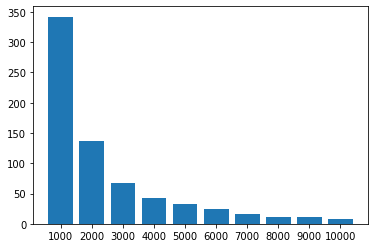

In [36]:
import matplotlib.pyplot as plt 
plt.bar(groups_dic.keys(), groups_dic.values())
plt.rcParams["figure.figsize"] = (40,10)

No handles with labels found to put in legend.


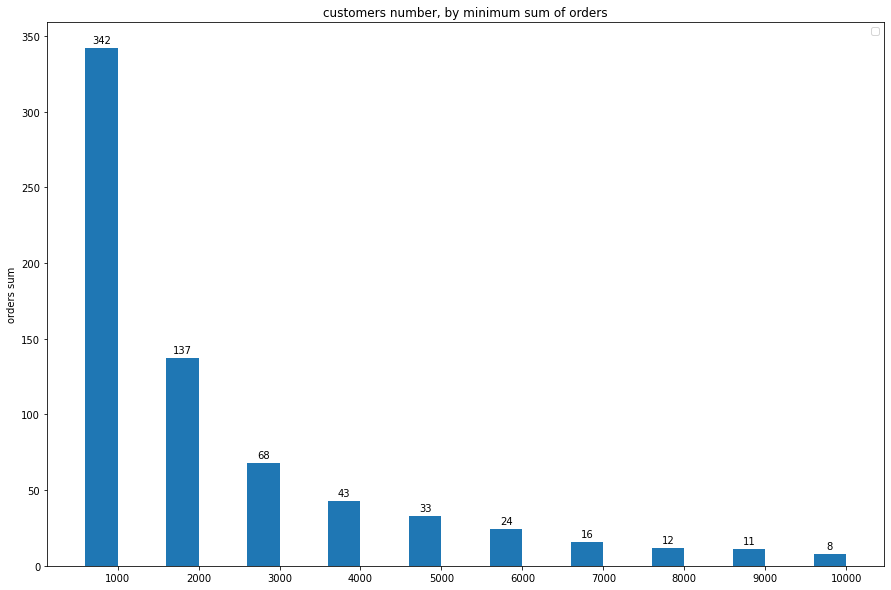

In [37]:
# with the help of - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = groups_dic.keys()
values = groups_dic.values()

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values, width, label='')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('orders sum')
ax.set_title('customers number, by minimum sum of orders')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height() 
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
fig.set_size_inches(15,10)

plt.show()

# choose the threshold, filter, and export

In [38]:
# filter by sum_of_orders
min_purchases_sum = 5000
df = df.loc[df.purchases_sum>min_purchases_sum]

In [39]:
len(df)

33

In [40]:
df.sort_values(by='purchases_sum',ascending=False, inplace=True)

In [ ]:
df.to_excel("top_32_first_try.xlsx")